In [28]:
import tensorflow as tf
from tensorflow import keras
# GPU on
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [29]:
import keras_tuner as kt

In [110]:
name = 'baikal_multi_0523_flat_pureMC_h5s2_norm.h5'
path_to_h5 = '../../data/' + name
model_name = 'tuner_bayes_nn_mask_1lstm_3resblocks_1lstm' + name[:-3]
batch_size = 256
import sys
sys.path.append('../')
sys.path.append('../nn_builds')
from ds_making import *

In [111]:
with h5.File(path_to_h5, 'r') as hf:
    total_num = hf['train/ev_ids_corr/data'].shape[0]
    steps_per_epoch = (total_num // batch_size) // 10

In [112]:
def make_tuner_dataset(bs = batch_size, path_to_h5 = path_to_h5):
    train_dataset = make_dataset(path_to_h5, regime = "train", batch_size = bs, shape=(None,6))
    #test_dataset = make_dataset(path_to_h5, regime = "test", batch_size = bs, shape=(None,6))
    return train_dataset

In [113]:
tuner_data = make_tuner_dataset()

### Создание модели

In [108]:
##### Architecture1 ######
# 1 LSTM layer (rs = True), mask is on
# 3 conv layers, cd, mask is on
# 1 LSTM layer (rs = False)
# 1 Dense (2,softmax)
#########################

In [114]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from nn_constructor import *
from nn_to_tune import *
import losses

class MyHyperModel(kt.HyperModel):
    
    def __init__(self):
        self.lr = 0.005
        self.bs = 256

    def build(self, hp, Shape = (None,6), is_mask = True):
        
        k_id_list = [0]*3
        f_id_list = [0]*3
        k_cd_list = [0]*3
        f_cd_list = [0]*3
        s_cd_list = [0]*3
        
        u1 = 8 #hp.Choice('u1',[8,16])
        
        k_id_list[0] = 8 #hp.Int('k0', 8,20,4)
        k_id_list[1] = 16 #hp.Int('k1', 8,20,4) #k_id_list[0] #hp.Choice('k1',[5,8])
        k_id_list[2] = 20 #hp.Int('k2', 8,20,4) #k_id_list[0] #hp.Choice('k2',[5,8])
        
        k_cd_list[0] = k_id_list[0]
        k_cd_list[1] = k_id_list[1]
        k_cd_list[2] = k_id_list[2]
        
        f_id_list[0] = 32 #hp.Choice('f_id_0', [32,64,128]) #hp.Choice('f_id_0', [16,32,64,96,128]) #hp.Int('f_id_0',16,256, step = 16) #f_id = f_cd
        f_id_list[1] = f_id_list[0] #hp.Choice('f_id_1', [96]) #hp.Choice('f_id_1', [16,32,64,96,128]) #hp.Int('f_id_1',16,256, step = 16)
        f_id_list[2] = f_id_list[0] #hp.Choice('f_id_2', [64]) #hp.Choice('f_id_2', [16,32,64,96,128]) #hp.Int('f_id_2',16,256, step = 16)
        
        f_cd_list[0] = f_id_list[0] #hp.Int('f_cd_0',16,256, step = 16)
        f_cd_list[1] = f_id_list[1] #hp.Int('f_cd_1',16,256, step = 16)
        f_cd_list[2] = f_id_list[2] #hp.Int('f_cd_2',16,256, step = 16)
        
        s_cd_list[0] = 2 #hp.Choice('s_cd_0',[2])
        s_cd_list[1] = 2 #hp.Choice('s_cd_1',[2])
        s_cd_list[2] = 2 #hp.Choice('s_cd_2',[2])
        u2 = 16 #hp.Choice('u2',[8,16])
        self.lr = 0.005 #hp.Choice('lr', [0.003,0.005,0.01, 0.015, 0.02]) #hp.Float("lr", min_value=1e-4, max_value=5e-2, sampling="log")
        
        model = nn_1LSTM_3RB_1LSTM(Shape, u1, u2, f_id_list, k_id_list, 
                                               f_cd_list, k_cd_list, s_cd_list)
        
        decay = hp.Choice('lr_decay', ['exp','pow_1','pow_0.5'])
        decay_steps = 5000
        
        if decay == 'exp':
            lrate = tf.keras.optimizers.schedules.ExponentialDecay(
                                    initial_learning_rate=self.lr, 
                                    decay_steps=decay_steps,
                                    decay_rate=0.05)
        else:
            lrate = tf.keras.optimizers.schedules.PolynomialDecay(
                                    initial_learning_rate=self.lr,
                                    decay_steps=decay_steps,
                                    end_learning_rate=1e-4,
                                    power=float(decay[4:]))
            
        optimizer = tf.keras.optimizers.Adam(self.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, 
                                             amsgrad=False, name='Adam')
        
        model.compile(optimizer=optimizer, loss=losses.focal_loss(2., 2., 10., 1.), 
                      metrics=[tf.keras.metrics.Recall(class_id=1, thresholds=0.5, name='E_0.5', dtype = tf.float64),
                               'accuracy',
                              tf.keras.metrics.Recall(class_id=0, thresholds=1. - 0.5, name='1-S_0.5', dtype = tf.float64)])
        
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args, batch_size=self.bs, 
                         verbose = True, **kwargs)

### Задаём tuner

In [115]:
# Оптимизируем lr

In [116]:
tuner = kt.GridSearch(
    MyHyperModel(),
    objective=kt.Objective("loss", direction="min"),
    max_trials = 10,
    overwrite=True,
    directory=model_name,
    project_name="tune_hypermodel",
    max_retries_per_trial=1,
)

In [119]:
tuner.search(tuner_data, epochs=5, steps_per_epoch = steps_per_epoch)#, validation_data=tuner_data[1])

Trial 3 Complete [00h 09m 55s]
loss: 0.04749308526515961

Best loss So Far: 0.04749308526515961
Total elapsed time: 00h 30m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Оптимизируем ядра

In [ ]:
# Оптимизируем фильтры

### Анализ результатов

In [123]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]
print(best_hps.values)

{'lr_decay': 'pow_0.5'}


In [124]:
# Return all trials from the oracle
trials = tuner.oracle.trials

# Get best loss value and corresponding hyperparams
l = []
for trial_id, trial in trials.items():
    l.append([trial.score, trial.hyperparameters.values])

In [125]:
l = [e for e in l if e[0]!=None]
l

[[0.05021613836288452, {'lr_decay': 'exp'}],
 [0.04833989590406418, {'lr_decay': 'pow_1'}],
 [0.04749308526515961, {'lr_decay': 'pow_0.5'}]]

In [55]:
objective3 = [l[i][0] for i in range(len(l))]
values3 = [l[i][1]['k0'] for i in range(len(l))]

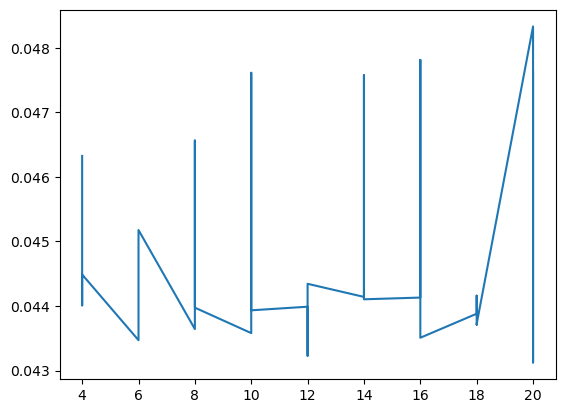

In [57]:
import matplotlib.pyplot as plt
plt.plot(values3, objective3)

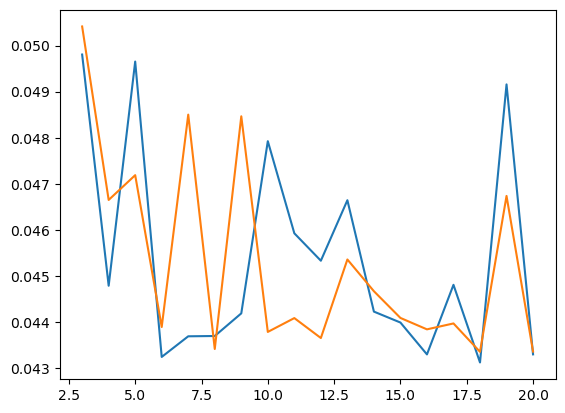

In [46]:
import matplotlib.pyplot as plt
plt.plot(values, objective)
plt.plot(values2, objective2)

In [65]:
l = sorted(l)
l = [[str(s) for s in e] for e in l]
results = np.array(l)
results

array([['0.04977881908416748',
        "{'k0': 8, 'k1': 16, 'k2': 20, 'f_id_0': 32}"],
       ['0.049856118857860565',
        "{'k0': 8, 'k1': 16, 'k2': 8, 'f_id_0': 64}"],
       ['0.050177544355392456',
        "{'k0': 8, 'k1': 12, 'k2': 16, 'f_id_0': 32}"],
       ['0.050224024802446365',
        "{'k0': 12, 'k1': 20, 'k2': 8, 'f_id_0': 32}"],
       ['0.05027295649051666',
        "{'k0': 12, 'k1': 16, 'k2': 8, 'f_id_0': 32}"],
       ['0.05032031983137131',
        "{'k0': 8, 'k1': 20, 'k2': 20, 'f_id_0': 32}"],
       ['0.050345323979854584',
        "{'k0': 12, 'k1': 16, 'k2': 12, 'f_id_0': 32}"],
       ['0.050407543778419495',
        "{'k0': 12, 'k1': 8, 'k2': 8, 'f_id_0': 32}"],
       ['0.05045253038406372',
        "{'k0': 12, 'k1': 20, 'k2': 16, 'f_id_0': 128}"],
       ['0.05047561973333359',
        "{'k0': 8, 'k1': 8, 'k2': 8, 'f_id_0': 32}"],
       ['0.05054573714733124',
        "{'k0': 20, 'k1': 16, 'k2': 12, 'f_id_0': 128}"],
       ['0.05063078925013542',
      

In [ ]:
lr_list = [float(e[1][7:-1]) for e in l]
value_list = [float(e[0]) for e in l]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lr_list,value_list,'.')
plt.grid()

In [ ]:
unique = np.unique(results[:,1])
average_score = np.ones((unique.shape[0],2))
for n,u in enumerate(unique):
    idxs = np.where(results[:,1] == u)[0]
    #print(len(idxs), u)
    average_score[n,0] = np.sum(np.float64(results[idxs,0]))/len(idxs)
    average_score[n,1] = len(idxs)

In [ ]:
L = [[]]
i = 0
for s,u in zip(average_score,unique):
    L[i].append(s[0])
    L[i].append(u)
    L[i].append(s[1])
    L.append([])
    i+=1
L = L[:-1]
with open(model_name+'/trials_info.txt', 'w') as f:
    for l in sorted(L):
        f.write(f"{l}\n")

In [ ]:
results[np.where(results[:,1] == "{'f_id_0': 64, 'f_id_1': 128, 'f_id_2': 64}")[0],0]

In [ ]:
results